In [10]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math
from sklearn.datasets import load_iris
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn import svm

import warnings
warnings.filterwarnings("ignore")

In [11]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 56165       ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf=1            ## value of resampling
session_now = 1
BINS = 70
FR_limit = 12
period = int(1 * sf / re_sf)
period_resting = period *10
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!

if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        colapse_behaviour = 1
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        if mouse == 32364:
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
        if mouse == 56165:
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   

    else:
        if session_now == 2:
            task = 'STABLE'
            colapse_behaviour = 2
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        else:
            task = 'RANDOM'
            colapse_behaviour = 0
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]           
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]

    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32366:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            object_fixed = 6
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]

In [12]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_unsup = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_unsupervised/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_parameters = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_parameters/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/center_of_mass/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/decoding/'

In [13]:
confusion_matrix_data_list = []
performance_sup = np.zeros((10,4))
performance_sup_std = np.zeros((10,4))

confusion_matrix_cca_list = []
performance_cca = np.zeros((10,4))
performance_cca_std = np.zeros((10,4))

# define all relevant files names and load them into a list
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
behaviour_list_unsup = []
parameters_list = []
tracking_list = []
total_time = 0
day = 0
confusion_matrix_data = []
confusion_matrix_pca = []
confusion_matrix_cca = []

print('LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR')
for trial in [1,6,11,16]:

    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_ethogram.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])

    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_parameters.npy'
    ## LOAD PARAMETRS FOR BEHAVIOUR CLASSIFICATION
    parameters = np.load(behaviour_dir_parameters + beh_file_name_1)
    params = []
    for param in range(parameters.shape[0]):
        r1_params = np.reshape(parameters[param,:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
        r2_params = np.reshape(scipy.stats.mode(r1_params,axis=1)[0],reshape_behaviour.shape[0])
        params.append(r2_params)
    resample_params = np.array(params)
        
    ## LOAD TRACKING
    tracking_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75.npy'
    position = np.load(tracking_dir + tracking_file_name_1)
    resample_position, resample_position_stc = stats.resample_matrix(neural_activity=position.T,
                                                                                            re_sf=re_sf)
    ## LOAD TIMELINE
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_'+ f'{trial}'+'_v1.3.1.0_10.pkl'

    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = behaviour.shape[0]
    timeline = timeline_1/re_sf
    time_lenght = 10
    resample_timeline = timeline_1/re_sf
    timeline_list.append(resample_timeline)

    behaviour_list.append(resample_beh1)
    parameters_list.append(resample_params)
    tracking_list.append(resample_position)
    total_time = total_time + behaviour.shape[0]


    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                            '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.0.npy'

     ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = neural_activity1
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                            re_sf=re_sf)

    activity_list.append(resample_neural_activity_mean)

    day = day + 1
        

LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR


In [14]:
    ## define targets of behaviour according to protocol (random, overlapping and stable)

    id_target = [0,1,2,3,4,5,6] # 0: unlabeled, 1:resting, 2:Navigation, 3: Obj1, 4:Obj2, 5:Run1, 6:Run2
    
    print('REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS')

    if colapse_behaviour == 0 : # RANDOM
        for day in range(len(behaviour_list)):
            for trial in range(5):
                behaviour_trial = behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])]
                objects = np.unique(behaviour_trial)
                selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
                index0 = np.where(behaviour_trial==objects[selected_object])[0]
                index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-4], behaviour_trial!=objects[selected_object]))
                index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-3], behaviour_trial!=objects[selected_object]))
                behaviour_trial[index0] = 3
                behaviour_trial[index1] = 4
                behaviour_trial[index2] = 4            

                index0 = np.where(behaviour_trial==objects[selected_object]+4)[0]
                index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-2], behaviour_trial!=objects[selected_object]+4))
                index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-1], behaviour_trial!=objects[selected_object]+4))
                behaviour_trial[index0] = 3
                behaviour_trial[index1] = 4
                behaviour_trial[index2] = 4 

                behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])] = behaviour_trial


    if colapse_behaviour == 1 : #OVERLAPPING
        for day in range(len(behaviour_list)):
            behaviour_list[day][np.where(behaviour_list[day] == object_fixed)[0]] = 100
            behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=3, behaviour_list[day]<=6))[0]] = 3
            behaviour_list[day][np.where(behaviour_list[day] == 100)[0]] = 4        
            behaviour_list[day][np.where(behaviour_list[day] == object_fixed +4)[0]] = 200        
            behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=7, behaviour_list[day]<=10))[0]] = 3
            behaviour_list[day][np.where(behaviour_list[day] == 200)[0]] = 4        


    if colapse_behaviour == 2: #STABLE
        for day in range(len(behaviour_list)):
            objects = np.unique(behaviour_list[day])
            selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
            index0 = np.where(behaviour_list[day]==objects[selected_object])[0]
            index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-4], behaviour_list[day]!=objects[selected_object]))
            index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-3], behaviour_list[day]!=objects[selected_object]))
            behaviour_list[day][index0] = 3
            behaviour_list[day][index1] = 4
            behaviour_list[day][index2] = 4      

            index0 = np.where(behaviour_list[day]==objects[selected_object]+4)[0]
            index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-2], behaviour_list[day]!=objects[selected_object]+4))
            index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-1], behaviour_list[day]!=objects[selected_object]+4))
            behaviour_list[day][index0] = 3
            behaviour_list[day][index1] = 4
            behaviour_list[day][index2] = 4  

            

REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS


In [15]:
print('DIMENSIONALITY REDUCCION AND TRAIN CLASSIFIER')
    
confusion_matrix_data_gnb_list = []
performance_gnb = np.zeros((20,))
performance_gnb_std = np.zeros((20,))

confusion_matrix_data_svm_list = []
performance_svm = np.zeros((20,))
performance_svm_std = np.zeros((20,))
    
confusion_matrix_pca_gnb_list = []
performance_pca_gnb = np.zeros((20,))
performance_pca_gnb_std = np.zeros((20,))

confusion_matrix_pca_svm_list = []
performance_pca_svm = np.zeros((20,))
performance_pca_svm_std = np.zeros((20,))
    
confusion_matrix_cca_gnb_list = []
performance_cca_gnb = np.zeros((20,))
performance_cca_gnb_std = np.zeros((20,))
    
confusion_matrix_cca_svm_list = []
performance_cca_svm = np.zeros((20,))
performance_cca_svm_std = np.zeros((20,))
    
confusion_matrix_data_gnb_shuffle_list = []
performance_gnb_shuffle = np.zeros((20,))
performance_gnb_shuffle_std = np.zeros((20,))

confusion_matrix_data_svm_shuffle_list = []
performance_svm_shuffle = np.zeros((20,))
performance_svm_shuffle_std = np.zeros((20,))
    
confusion_matrix_pca_gnb_shuffle_list = []
performance_pca_gnb_shuffle = np.zeros((20,))
performance_pca_gnb_shuffle_std = np.zeros((20,))

confusion_matrix_pca_svm_shuffle_list = []
performance_pca_svm_shuffle = np.zeros((20,))
performance_pca_svm_shuffle_std = np.zeros((20,))
    
confusion_matrix_cca_gnb_shuffle_list = []
performance_cca_gnb_shuffle = np.zeros((20,))
performance_cca_gnb_shuffle_std = np.zeros((20,))
    
confusion_matrix_cca_svm_shuffle_list = []
performance_cca_svm_shuffle = np.zeros((20,))
performance_cca_svm_shuffle_std = np.zeros((20,))
        
dim = 2
for day in [0,1,2,3]: 
    for trial in range(5):
        print(day*5+trial)
        time0 = int(timeline_list[day][trial*2])
        time1 = int(timeline_list[day][trial*2+1])

        tracking_trial = tracking_list[day][:,time0:time1]
        behaviour_trial = behaviour_list[day][time0:time1]
        parameters_trial = parameters_list[day][:,time0:time1]
        index_track = np.where(behaviour_trial>2)[0]

        conf_gnb = np.zeros((dim,dim))
        conf_pca_gnb = np.zeros((dim,dim))
        conf_cca_gnb = np.zeros((dim,dim))

        conf_svm = np.zeros((dim,dim))
        conf_pca_svm = np.zeros((2,2))
        conf_cca_svm =np.zeros((2,2))
                
        conf_gnb_shuffle = np.zeros((2,2))
        conf_pca_gnb_shuffle = np.zeros((2,2))
        conf_cca_gnb_shuffle = np.zeros((2,2))

        conf_svm_shuffle = np.zeros((2,2))
        conf_pca_svm_shuffle = np.zeros((2,2))
        conf_cca_svm_shuffle = np.zeros((2,2))
        
        
        if index_track.shape[0] > 0:
            ybehaviour= behaviour_trial[index_track]
            yparameters = parameters_trial[:,index_track]

            ### prepare neural data
            Xpre = activity_list[day][:,time0:time1].T
            Xpre = Xpre[index_track,:]    
            firing_rate = np.mean(Xpre,axis = 0)*10
            selected_cells = np.where(firing_rate < FR_limit)[0]
            Xpre = Xpre[:,selected_cells]

    #         ### select tracking parts of the experiment
    #         tracking = tracking_list[day]
    #         ### select objects exploration and running towards the objects
    #         index_track = np.where(behaviour_list[day]>2)[0]

    #         ybehaviour = behaviour_list[day][index_track]
    #         yparameters = parameters_list[day][:,index_track]

    #         ### prepare neural data
    #         Xpre = activity_list[day].T
    #         Xpre = Xpre[index_track,:]
    #         firing_rate = np.mean(Xpre,axis = 0)*10
    #         selected_cells = np.where(firing_rate < FR_limit)[0]
    #         Xpre = Xpre[:,selected_cells]

            ### solve class inbalance by taking the minimun occupancy lengh supervised
            min_exploration = Xpre.shape[0]
            for i in range(3,5):
                exploration = np.where(ybehaviour == i)[0].shape[0]
                if exploration < min_exploration and exploration!=0: min_exploration = exploration 
            selected_temporal_bins = []
            for i in range(3,5):
                exploration = list(np.where(ybehaviour == i)[0])
                selection = random.sample(exploration, min_exploration)
                selected_temporal_bins = selected_temporal_bins + selection

            X = Xpre[selected_temporal_bins,:]
            Xshuffle = np.random.permutation(X)
            #np.random.shuffle(Xshuffle)

            ybehaviour = ybehaviour[selected_temporal_bins]
            yparameters = yparameters[:,selected_temporal_bins]

            #train classifier in data gnb and svm
            gnb = GaussianNB()
            X_train, X_test, y_train, y_test, y_train_params, y_test_params = train_test_split(X, ybehaviour, yparameters.T, test_size=0.1, random_state=0)
            y_pred = gnb.fit(X_train, y_train).predict(X_test)
            conf_gnb = confusion_matrix(y_test,y_pred)
            scores = cross_val_score(gnb, X_train, y_train, cv=10)
            performance_gnb[day*5+trial] =  np.mean(scores)
            performance_gnb_std[day*5+trial] =  np.std(scores)

            svmclass = svm.SVC()
            y_pred = svmclass.fit(X_train, y_train).predict(X_test)
            conf_svm = confusion_matrix(y_test,y_pred)
            scores = cross_val_score(svmclass, X_train, y_train, cv=10)
            performance_svm[day*5+trial] =  np.mean(scores)
            performance_svm_std[day*5+trial] =  np.std(scores)

            # do decoding but first do dim reduction with pca with pipeline    
            pipe_pca = Pipeline([('pca', PCA()), ('NGauss', GaussianNB())])
            pipe_pca.set_params(pca__n_components= min(8,X.shape[1]))
            scores = cross_val_score(pipe_pca, X_train, y_train, cv=10)
            ##confusion per class
            X1, X2, y1, y2 = train_test_split(X_train, y_train, test_size=0.1, random_state=0)
            y_pred = pipe_pca.fit(X1,y1).predict(X2)
            conf_pca_gnb = confusion_matrix(y2,y_pred)
            performance_pca_gnb[day*5+trial] =  np.mean(scores)
            performance_pca_gnb_std[day*5+trial] =  np.std(scores)

            pipe_pca_svm = Pipeline([('pca', PCA()), ('SVM', svm.SVC())])
            pipe_pca_svm.set_params(pca__n_components = min(8,X.shape[1]))
            scores = cross_val_score(pipe_pca_svm, X_train, y_train, cv=10)
            ##confusion per class
            X1, X2, y1, y2 = train_test_split(X_train, y_train, test_size=0.1, random_state=0)
            y_pred = pipe_pca_svm.fit(X1,y1).predict(X2)
            conf_pca_svm = confusion_matrix(y2,y_pred)
            performance_pca_svm[day*5+trial]=  np.mean(scores)
            performance_pca_svm_std[day*5+trial] =  np.std(scores)


            # do the same decoding but firts doing a dim reduction by cca    
            cca = CCA(n_components=min(8,X.shape[1]))
            kf = KFold(n_splits=10)
            i= 0
            scores_gnb = np.zeros((10,))
            scores_svm = np.zeros((10,))
            for train_index, test_index in kf.split(X_train):
                X_train_cca, X_test_cca = X_train[train_index], X_train[test_index]
                y_train_cca, y_test_cca = y_train_params[train_index], y_train_params[test_index]
                y_train_gnb, y_test_gnb = y_train[train_index], y_train[test_index]

                #X_train_cca, X_test_cca, y_train_cca, y_test_cca , y_train_gnb, y_test_gnb = train_test_split(X_train, y_train_params, y_train, test_size=0.1, random_state=0)
                X_cca_train = cca.fit(X_train_cca, y_train_cca).transform(X_train_cca)
                X_cca_test = cca.fit(X_train_cca, y_train_cca).transform(X_test_cca)
                y_pred_gnb = gnb.fit(X_cca_train, y_train_gnb).predict(X_cca_test)
                y_pred_svm = svmclass.fit(X_cca_train, y_train_gnb).predict(X_cca_test)

                scores_gnb[i] = gnb.fit(X_cca_train, y_train_gnb).score(X_cca_test, y_test_gnb)
                scores_svm[i] = svmclass.fit(X_cca_train, y_train_gnb).score(X_cca_test, y_test_gnb)
                i = i+1
            conf_cca_gnb = confusion_matrix(y_test_gnb,y_pred_gnb)
            conf_cca_svm = confusion_matrix(y_test_gnb,y_pred_svm)
            performance_cca_gnb[day*5+trial] =  np.mean(scores_gnb)
            performance_cca_gnb_std[day*5+trial] =  np.std(scores_gnb)
            performance_cca_svm[day*5+trial] =  np.mean(scores_svm)
            performance_cca_svm_std[day*5+trial] =  np.std(scores_svm)


            #train classifier gnv and svm in shuffle data
            X_train, X_test, y_train, y_test, y_train_params, y_test_params = train_test_split(Xshuffle, ybehaviour, yparameters.T, test_size=0.1, random_state=0)
            y_pred = gnb.fit(X_train, y_train).predict(X_test)
            conf_gnb_shuffle = confusion_matrix(y_test,y_pred)
            scores = cross_val_score(gnb, X_train, y_train, cv=10)
            performance_gnb_shuffle[day*5+trial] =  np.mean(scores)
            performance_gnb_shuffle_std[day*5+trial] =  np.std(scores)

            y_pred = svmclass.fit(X_train, y_train).predict(X_test)
            conf_svm_shuffle = confusion_matrix(y_test,y_pred)
            scores = cross_val_score(svmclass, X_train, y_train, cv=10)
            performance_svm_shuffle[day*5+trial] =  np.mean(scores)
            performance_svm_shuffle_std[day*5+trial] =  np.std(scores)   

            # do decoding but first do dim reduction with pca with pipeline    
            pipe_pca = Pipeline([('pca', PCA()), ('NGauss', GaussianNB())])
            pipe_pca_svm.set_params(pca__n_components = min(8,X.shape[1]))
            scores = cross_val_score(pipe_pca, X_train, y_train, cv=10)
            ##confusion per class
            X1, X2, y1, y2 = train_test_split(X_train, y_train, test_size=0.1, random_state=0)
            y_pred = pipe_pca.fit(X1,y1).predict(X2)
            conf_pca_gnb_shuffle = confusion_matrix(y2,y_pred)
            performance_pca_gnb_shuffle[day*5+trial] =  np.mean(scores)
            performance_pca_gnb_shuffle_std[day*5+trial] =  np.std(scores)

            pipe_pca_svm = Pipeline([('pca', PCA()), ('SVM', svm.SVC())])
            pipe_pca_svm.set_params(pca__n_components = min(8,X.shape[1]))
            scores = cross_val_score(pipe_pca_svm, X_train, y_train, cv=10)
            ##confusion per class
            X1, X2, y1, y2 = train_test_split(X_train, y_train, test_size=0.1, random_state=0)
            y_pred = pipe_pca_svm.fit(X1,y1).predict(X2)
            conf_pca_svm_shuffle = confusion_matrix(y2,y_pred)
            performance_pca_svm_shuffle[day*5+trial]=  np.mean(scores)
            performance_pca_svm_shuffle_std[day*5+trial] =  np.std(scores)


            # do the same decoding but firts doing a dim reduction by cca    
            cca = CCA(n_components=min(8,X.shape[1]))
            kf = KFold(n_splits=10)
            i= 0
            scores_gnb = np.zeros((10,))
            scores_svm = np.zeros((10,))
            for train_index, test_index in kf.split(X_train):
                X_train_cca, X_test_cca = X_train[train_index], X_train[test_index]
                y_train_cca, y_test_cca = y_train_params[train_index], y_train_params[test_index]
                y_train_gnb, y_test_gnb = y_train[train_index], y_train[test_index]

                #X_train_cca, X_test_cca, y_train_cca, y_test_cca , y_train_gnb, y_test_gnb = train_test_split(X_train, y_train_params, y_train, test_size=0.1, random_state=0)
                X_cca_train = cca.fit(X_train_cca, y_train_cca).transform(X_train_cca)
                X_cca_test = cca.fit(X_train_cca, y_train_cca).transform(X_test_cca)
                y_pred_gnb = gnb.fit(X_cca_train, y_train_gnb).predict(X_cca_test)
                y_pred_svm = svmclass.fit(X_cca_train, y_train_gnb).predict(X_cca_test)

                scores_gnb[i] = gnb.fit(X_cca_train, y_train_gnb).score(X_cca_test, y_test_gnb)
                scores_svm[i] = svmclass.fit(X_cca_train, y_train_gnb).score(X_cca_test, y_test_gnb)
                i = i+1
            conf_cca_gnb_shuffle = confusion_matrix(y_test_gnb,y_pred_gnb)
            conf_cca_svm_shuffle = confusion_matrix(y_test_gnb,y_pred_svm)
            performance_cca_gnb_shuffle[day*5+trial] =  np.mean(scores_gnb)
            performance_cca_gnb_shuffle_std[day*5+trial] =  np.std(scores_gnb)
            performance_cca_svm_shuffle[day*5+trial] =  np.mean(scores_svm)
            performance_cca_svm_shuffle_std[day*5+trial] =  np.std(scores_svm)
        
        
        confusion_matrix_data_gnb_list.append(conf_gnb)
        confusion_matrix_pca_gnb_list.append(conf_pca_gnb)
        confusion_matrix_cca_gnb_list.append(conf_cca_gnb)

        confusion_matrix_data_svm_list.append(conf_svm)
        confusion_matrix_pca_svm_list.append(conf_pca_svm)
        confusion_matrix_cca_svm_list.append(conf_cca_svm)
        
                
        confusion_matrix_data_gnb_shuffle_list.append(conf_gnb_shuffle)
        confusion_matrix_pca_gnb_shuffle_list.append(conf_pca_gnb_shuffle)
        confusion_matrix_cca_gnb_shuffle_list.append(conf_cca_gnb_shuffle)

        confusion_matrix_data_svm_shuffle_list.append(conf_svm_shuffle)
        confusion_matrix_pca_svm_shuffle_list.append(conf_pca_svm_shuffle)
        confusion_matrix_cca_svm_shuffle_list.append(conf_cca_svm_shuffle)


DIMENSIONALITY REDUCCION AND TRAIN CLASSIFIER
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


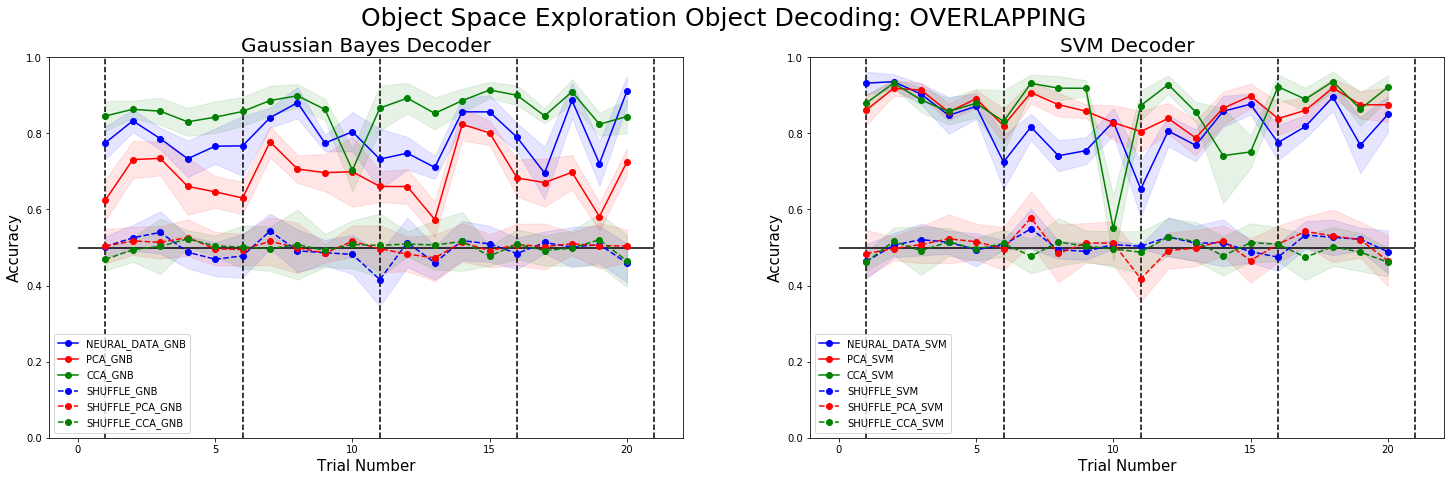

In [17]:
fig,ax = plt.subplots(1,2,figsize = (25,7))

ax[0].plot(np.arange(1,21),performance_gnb,color = 'b', marker='o', linestyle='-')
ax[0].fill_between(np.arange(1,21),performance_gnb-performance_gnb_std, performance_gnb+performance_gnb_std,alpha = 0.1,edgecolor='b', facecolor='b')

ax[0].plot(np.arange(1,21),performance_pca_gnb,color = 'r', marker='o', linestyle='-')
ax[0].fill_between(np.arange(1,21),performance_pca_gnb-performance_pca_gnb_std, performance_pca_gnb+performance_pca_gnb_std,alpha = 0.1,edgecolor='r', facecolor='r')

ax[0].plot(np.arange(1,21),performance_cca_gnb,color = 'g', marker='o', linestyle='-')
ax[0].fill_between(np.arange(1,21),performance_cca_gnb-performance_cca_gnb_std, performance_cca_gnb+performance_cca_gnb_std,alpha = 0.1,edgecolor='g', facecolor='g')


ax[0].plot(np.arange(1,21),performance_gnb_shuffle,color = 'b', marker='o', linestyle='--')
ax[0].fill_between(np.arange(1,21),performance_gnb_shuffle-performance_gnb_shuffle_std, performance_gnb_shuffle+performance_gnb_shuffle_std,alpha = 0.1,edgecolor='b', facecolor='b')

ax[0].plot(np.arange(1,21),performance_pca_gnb_shuffle,color = 'r', marker='o', linestyle='--')
ax[0].fill_between(np.arange(1,21),performance_pca_gnb_shuffle-performance_pca_gnb_shuffle_std, performance_pca_gnb_shuffle+performance_pca_gnb_shuffle_std,alpha = 0.1,edgecolor='r', facecolor='r')

ax[0].plot(np.arange(1,21),performance_cca_gnb_shuffle,color = 'g', marker='o', linestyle='--')
ax[0].fill_between(np.arange(1,21),performance_cca_gnb_shuffle-performance_cca_gnb_shuffle_std, performance_cca_gnb_shuffle+performance_cca_gnb_shuffle_std,alpha = 0.1,edgecolor='g', facecolor='g')


ax[1].plot(np.arange(1,21),performance_svm, color = 'b', marker='o', linestyle='-')
ax[1].fill_between(np.arange(1,21),performance_svm-performance_svm_std, performance_svm+performance_svm_std,alpha = 0.1,edgecolor='b', facecolor='b')

ax[1].plot(np.arange(1,21),performance_pca_svm,color = 'r', marker='o', linestyle='-')
ax[1].fill_between(np.arange(1,21),performance_pca_svm-performance_pca_svm_std, performance_pca_svm+performance_pca_svm_std,alpha = 0.1,edgecolor='r', facecolor='r')

ax[1].plot(np.arange(1,21),performance_cca_svm,color = 'g', marker='o', linestyle='-')
ax[1].fill_between(np.arange(1,21),performance_cca_svm-performance_cca_svm_std, performance_cca_svm+performance_cca_svm_std,alpha = 0.1,edgecolor='g', facecolor='g')


ax[1].plot(np.arange(1,21),performance_svm_shuffle, color = 'b', marker='o', linestyle='--')
ax[1].fill_between(np.arange(1,21),performance_svm_shuffle-performance_svm_shuffle_std, performance_svm_shuffle+performance_svm_shuffle_std,alpha = 0.1,edgecolor='b', facecolor='b')

ax[1].plot(np.arange(1,21),performance_pca_svm_shuffle,color = 'r', marker='o', linestyle='--')
ax[1].fill_between(np.arange(1,21),performance_pca_svm_shuffle-performance_pca_svm_shuffle_std, performance_pca_svm_shuffle+performance_pca_svm_shuffle_std,alpha = 0.1,edgecolor='r', facecolor='r')

ax[1].plot(np.arange(1,21),performance_cca_svm_shuffle,color = 'g', marker='o', linestyle='--')
ax[1].fill_between(np.arange(1,21),performance_cca_svm_shuffle-performance_cca_svm_shuffle_std, performance_cca_svm_shuffle+performance_cca_svm_shuffle_std,alpha = 0.1,edgecolor='g', facecolor='g')


ax[0].set_title('Gaussian Bayes Decoder', fontsize = 20)
ax[1].set_title('SVM Decoder', fontsize = 20)

for i in range(2):
    ax[i].set_ylabel('Accuracy',fontsize = 15)
    ax[i].set_xlabel('Trial Number',fontsize = 15)
    ax[i].set_ylim([0,1])
    ax[i].vlines(1, 0, 1, colors='k', linestyles='--')
    ax[i].vlines(6, 0, 1, colors='k', linestyles='--')
    ax[i].vlines(11, 0, 1, colors='k', linestyles='--')
    ax[i].vlines(16, 0, 1, colors='k', linestyles='--')
    ax[i].vlines(21, 0, 1, colors='k', linestyles='--')
    ax[i].hlines(1/2, 0, 21, colors='k', linestyles='-') 
ax[0].legend(['NEURAL_DATA_GNB','PCA_GNB','CCA_GNB','SHUFFLE_GNB','SHUFFLE_PCA_GNB','SHUFFLE_CCA_GNB'])
ax[1].legend(['NEURAL_DATA_SVM','PCA_SVM','CCA_SVM','SHUFFLE_SVM','SHUFFLE_PCA_SVM','SHUFFLE_CCA_SVM'])

figure_name = figure_path +'decorder_ObjectSpace_'+f'{mouse}'+'_session_'+f'{session}'+'.png'
fig.suptitle('Object Space Exploration Object Decoding: ' + task , fontsize = 25)
fig.savefig(figure_name)

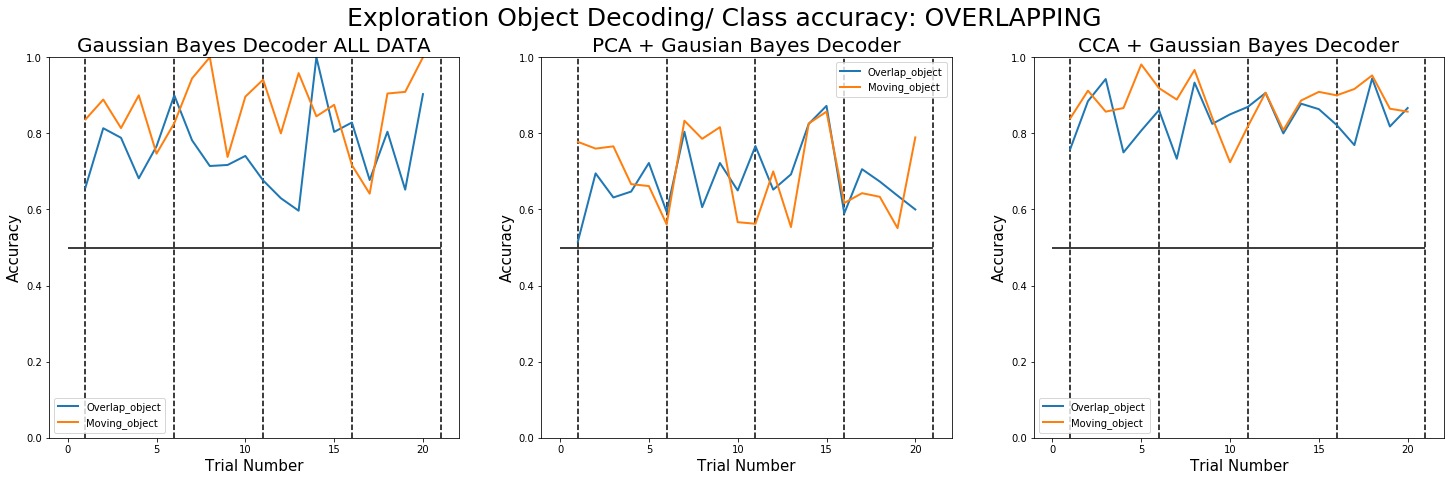

In [18]:
fig,ax = plt.subplots(1,3,figsize = (25,7))

#conditions = labels[3,5]

class_accuracy_gnb = np.zeros((20,2))
class_accuracy_pca_gnb= np.zeros((20,2))
class_accuracy_cca_gnb = np.zeros((20,2))

class_accuracy_svm = np.zeros((20,2))
class_accuracy_pca_svm = np.zeros((20,2))
class_accuracy_cca_svm = np.zeros((20,2))

for day in [0,1,2,3]:
    for trial in range(5):
        i = day*5+trial
        accuracy = (confusion_matrix_data_gnb_list[i]/np.sum(confusion_matrix_data_gnb_list[i],axis=0)).diagonal()
        class_accuracy_gnb[i,:] = accuracy
        
        accuracy = (confusion_matrix_pca_gnb_list[i]/np.sum(confusion_matrix_pca_gnb_list[i],axis=0)).diagonal()
        class_accuracy_pca_gnb[i,:] = accuracy
        
        accuracy = (confusion_matrix_cca_gnb_list[i]/np.sum(confusion_matrix_cca_gnb_list[i],axis=0)).diagonal()
        class_accuracy_cca_gnb[i,:] = accuracy

        
ax[0].plot(np.arange(1,21),class_accuracy_gnb, linewidth = 2)    
ax[1].plot(np.arange(1,21),class_accuracy_pca_gnb,linewidth = 2)
ax[2].plot(np.arange(1,21),class_accuracy_cca_gnb,linewidth = 2)   

for i in range(3):
    ax[i].set_ylabel('Accuracy',fontsize = 15)
    ax[i].set_xlabel('Trial Number',fontsize = 15)
    ax[i].set_ylim([0,1])
    ax[i].vlines(1, 0, 1, colors='k', linestyles='--')
    ax[i].vlines(6, 0, 1, colors='k', linestyles='--')
    ax[i].vlines(11, 0, 1, colors='k', linestyles='--')
    ax[i].vlines(16, 0, 1, colors='k', linestyles='--')
    ax[i].vlines(21, 0, 1, colors='k', linestyles='--')
    ax[i].hlines(1/2, 0, 21, colors='k', linestyles='-') 
    ax[i].legend([labels[3],labels[4]])
    
ax[0].set_title('Gaussian Bayes Decoder ALL DATA', fontsize = 20)
ax[1].set_title('PCA + Gausian Bayes Decoder', fontsize = 20)
ax[2].set_title('CCA + Gaussian Bayes Decoder', fontsize = 20)

fig.suptitle('Exploration Object Decoding/ Class accuracy: ' + task , fontsize = 25)

figure_name = figure_path +'decorder_ObjectSpace_class_accuracy_'+f'{mouse}'+'_session_'+f'{session}'+'.png'
fig.savefig(figure_name)

In [73]:
min(8,X.shape[1])

8